## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Import

In [1]:
#import
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

---
## 2. Line object used in line detection

In [2]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  

---
## 3. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.


In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

# Calibration
ret, cal_mtx, cal_dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)

def cal_undistort(img):
    return cv2.undistort(img, cal_mtx, cal_dist, None, cal_mtx)

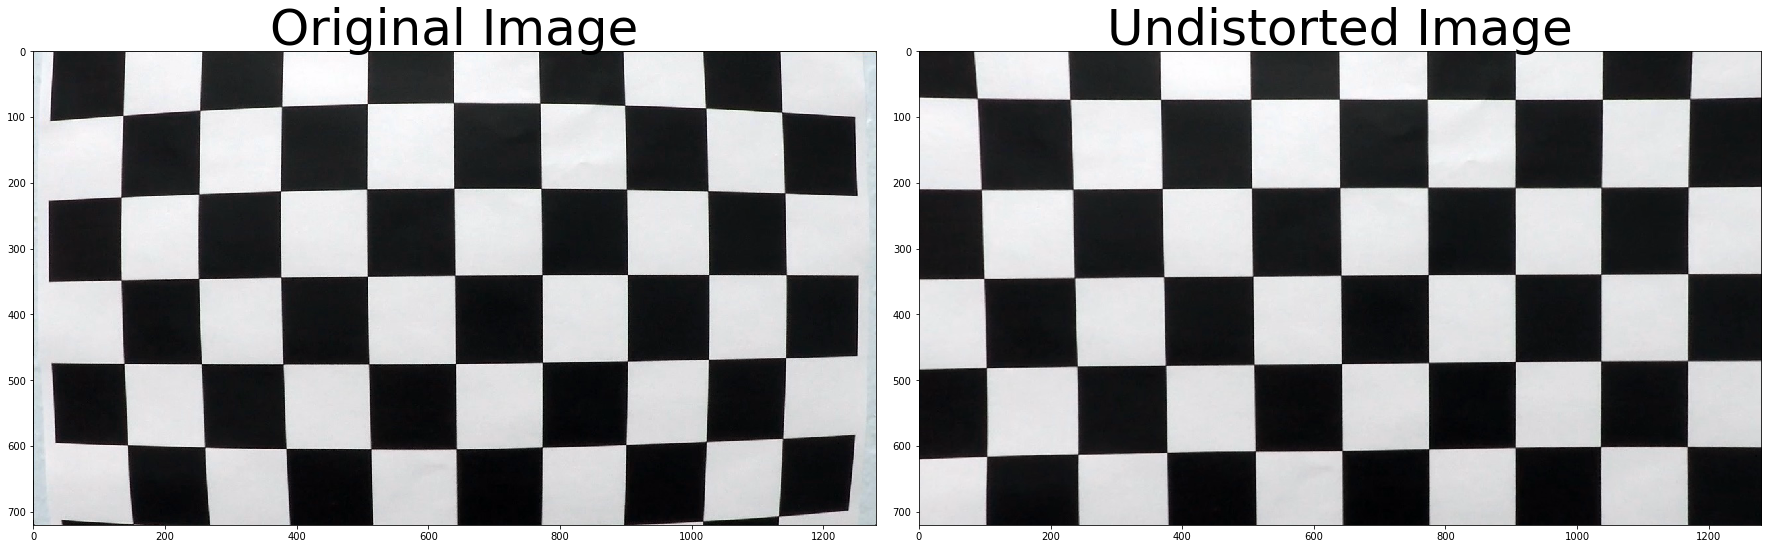

In [4]:
images = glob.glob('../camera_cal/calibration*.jpg')
tst_img = cv2.imread(images[0])
undistorted = cal_undistort(tst_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(tst_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig("../output_images/undistort.jpg")

---
## 4. Use color transforms, gradients, etc., to create a thresholded binary image.

In [5]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the derivative in x or y given orient = 'x' or 'y', take absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y': 
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output
    
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    magnitude = np.sqrt(sobelx*sobelx + sobely*sobely)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(magnitude)/255 
    magnitude = (magnitude/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(magnitude)
    binary_output[(magnitude >= mag_thresh[0]) & (magnitude <= mag_thresh[1])] = 1
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def union(img1, img2):
    # Combine two binary thresholds
    combined_binary = np.zeros_like(img1)
    combined_binary[(img1 == 1) | (img2 == 1)] = 1
    return combined_binary

def intersection(img1, img2):
    # Combine two binary thresholds
    combined_binary = np.zeros_like(img1)
    combined_binary[(img1 == 1) & (img2 == 1)] = 1
    return combined_binary

def binary_image(img, sx_thresh=(60,120), s_thresh=(120, 255)):
    #gradient
    sobel_binary = mag_thresh(img, sobel_kernel=5, mag_thresh=sx_thresh)
    
    #HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    return union(sobel_binary, s_binary)

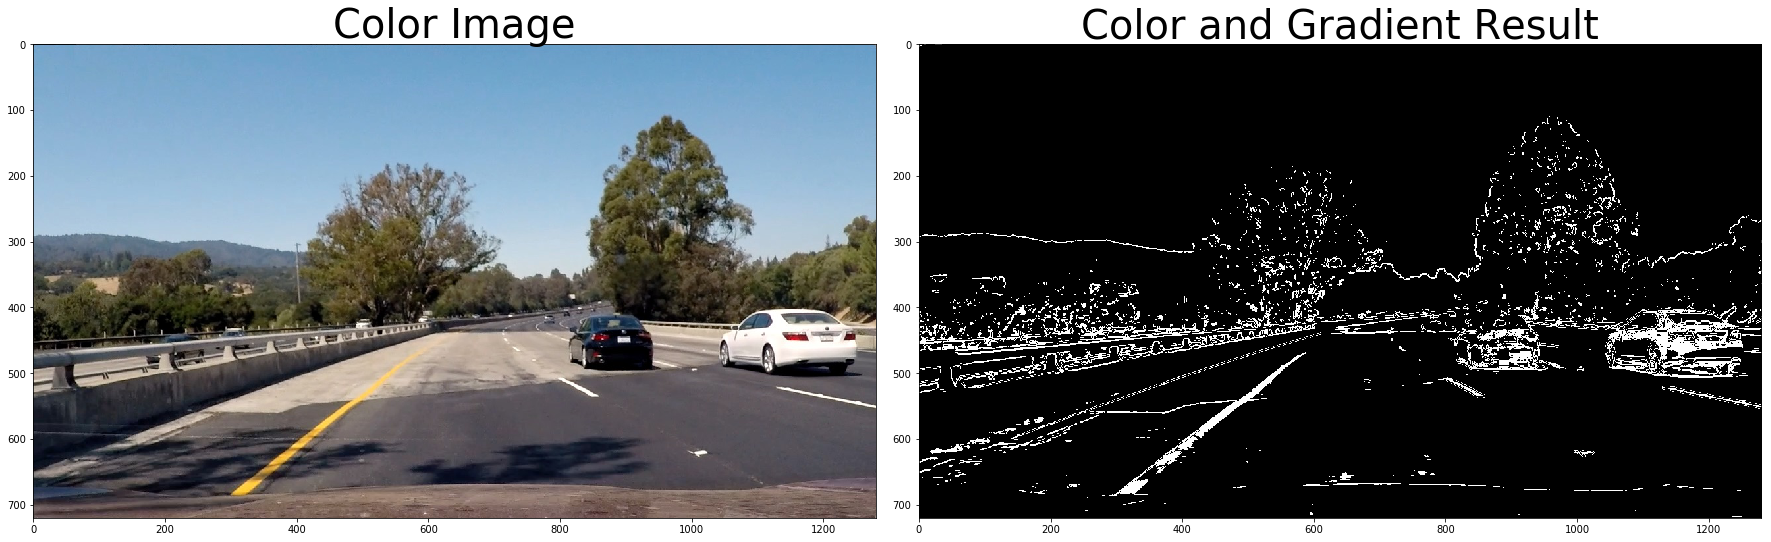

In [6]:
images = glob.glob('../test_images/test*.jpg')
tst_img = mpimg.imread(images[3])
result = binary_image(tst_img, sx_thresh=(60,120), s_thresh=(170, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(tst_img)
ax1.set_title('Color Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Color and Gradient Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig("../output_images/binary.jpg")

---
## 5. Apply a perspective transform to rectify binary image ("birds-eye view")


In [7]:
def perspective_transform(img):
    size = (img.shape[1], img.shape[0])

    # apply a mask to src image to substract the lane
    src = np.float32([[602,450], [270,720], [1080,720], [682,450]])
    dst = np.float32([[320,0], [320,720], [960,720], [960,0]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, size)

    return warped, M

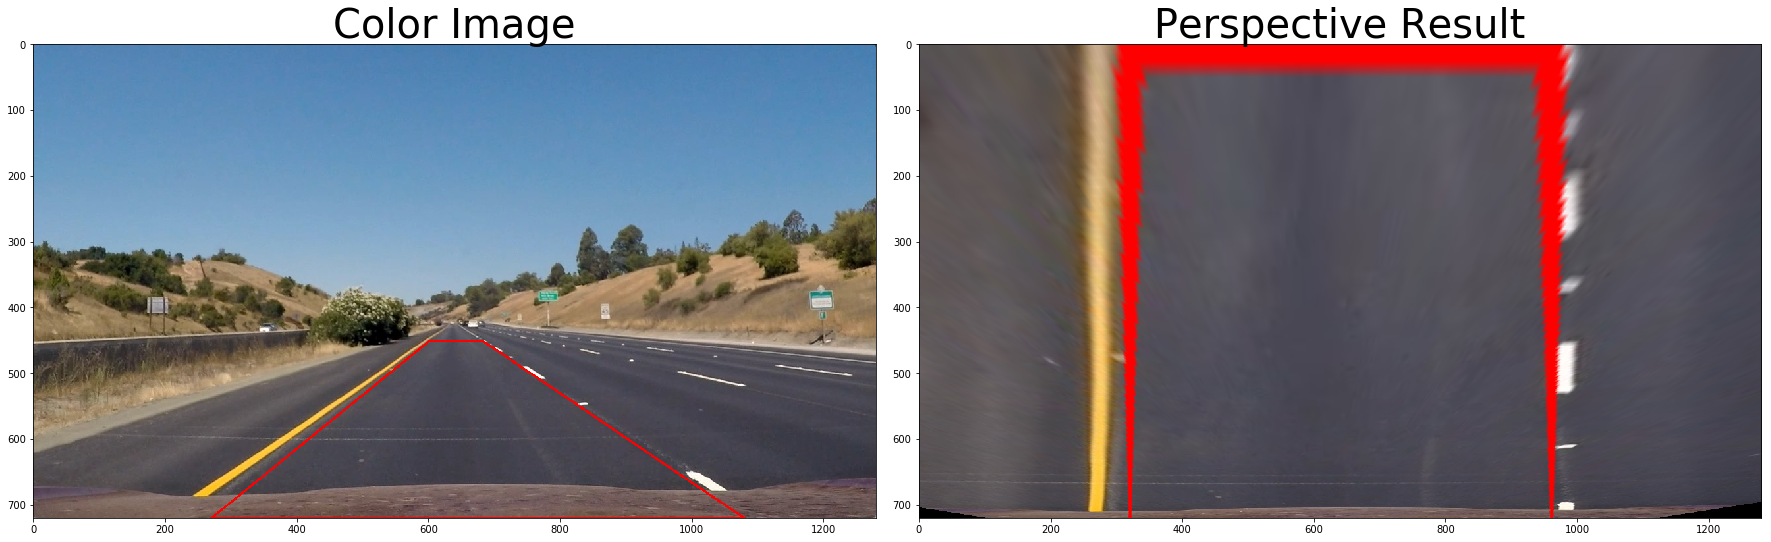

In [8]:
images = glob.glob('../test_images/straight*.jpg')

tst_img = mpimg.imread(images[0])

# draw polygon on src image
pts = np.array([[602,450], [270,720], [1080,720], [682,450]], np.int32)
tst_img = cv2.polylines(tst_img,[pts],True,(255,0,0), thickness=2)

warped, M = perspective_transform(tst_img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(tst_img)
ax1.set_title('Color Image', fontsize=40)

ax2.imshow(warped)
ax2.set_title('Perspective Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig("../output_images/perspective.jpg")

---
## 6. Detect lane pixels and fit to find the lane boundary.

In [9]:
def sanity_sliding_window(left_fitx, right_fitx):
    diff = right_fitx - left_fitx
    # Lane is about 3.7m(700 pixels) wide, two lines are roughly parallel
    isRightWidth = (diff[-1] <= 800) & (diff[-1] >= 650)
    isParallel = (np.min(diff) > 300) & (np.max(diff) < 900)
    return isRightWidth & isParallel

def sanity_look_ahead(left_fitx, right_fitx, line):    
    left_diff = np.abs(line.recent_xfitted[0] - left_fitx)
    right_diff = np.abs(line.recent_xfitted[1]- right_fitx)
    return (np.max(left_diff) < 30) & (np.max(right_diff) < 30)
    
def update_cache(left_fitx, right_fitx, left_fit, right_fit, line):
    if line.detected:
        line.bestx[0] = line.bestx[0]*0.3 + line.recent_xfitted[0]*0.3 + left_fitx*0.4
        line.bestx[1] = line.bestx[1]*0.3 + line.recent_xfitted[1]*0.3 + right_fitx*0.4
        line.best_fit[0] = np.polyfit(ploty, line.bestx[0], 2)
        line.best_fit[1] = np.polyfit(ploty, line.bestx[1], 2)
        line.recent_xfitted = np.vstack((left_fitx, right_fitx))
        line.current_fit = np.vstack((left_fit, right_fit))
    else:
        line.detected = True
        line.recent_xfitted = np.vstack((left_fitx, right_fitx))
        line.bestx = line.recent_xfitted
        line.best_fit = np.vstack((left_fit, right_fit))
        line.current_fit = line.best_fit
    
    return line

def sliding_window(img, count, line):
    # hisgogram of bottom half of the img
    histogram = np.sum(img[np.int(img.shape[0]/2):,:], axis=0)
    output = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(output,(win_xleft_high,win_y_high),(win_xleft_low,win_y_low),(0,255,0), 2)
        cv2.rectangle(output,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    
    if sanity_sliding_window(left_fitx, right_fitx):
        return update_cache(left_fitx, right_fitx, left_fit, right_fit, line)
    else:
        print("Sliding window sanity check failed for image {0}, skip this frame".format(count))
        return line
    
def look_ahead(img, count, line):
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_fit, right_fit = line.current_fit[0], line.current_fit[1]

    left_line = left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2]
    right_line = right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2]
    left_lane_inds = ((nonzerox > (left_line - margin)) & (nonzerox < (left_line + margin))) 
    right_lane_inds = ((nonzerox > (right_line - margin)) & (nonzerox < (right_line + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    if sanity_look_ahead(left_fitx, right_fitx, line):
        return update_cache(left_fitx, right_fitx, left_fit, right_fit, line)
    else:
        print("Look ahead sanity check failed for image {}, fallback to sliding window".format(count))
        return sliding_window(img, count, line)

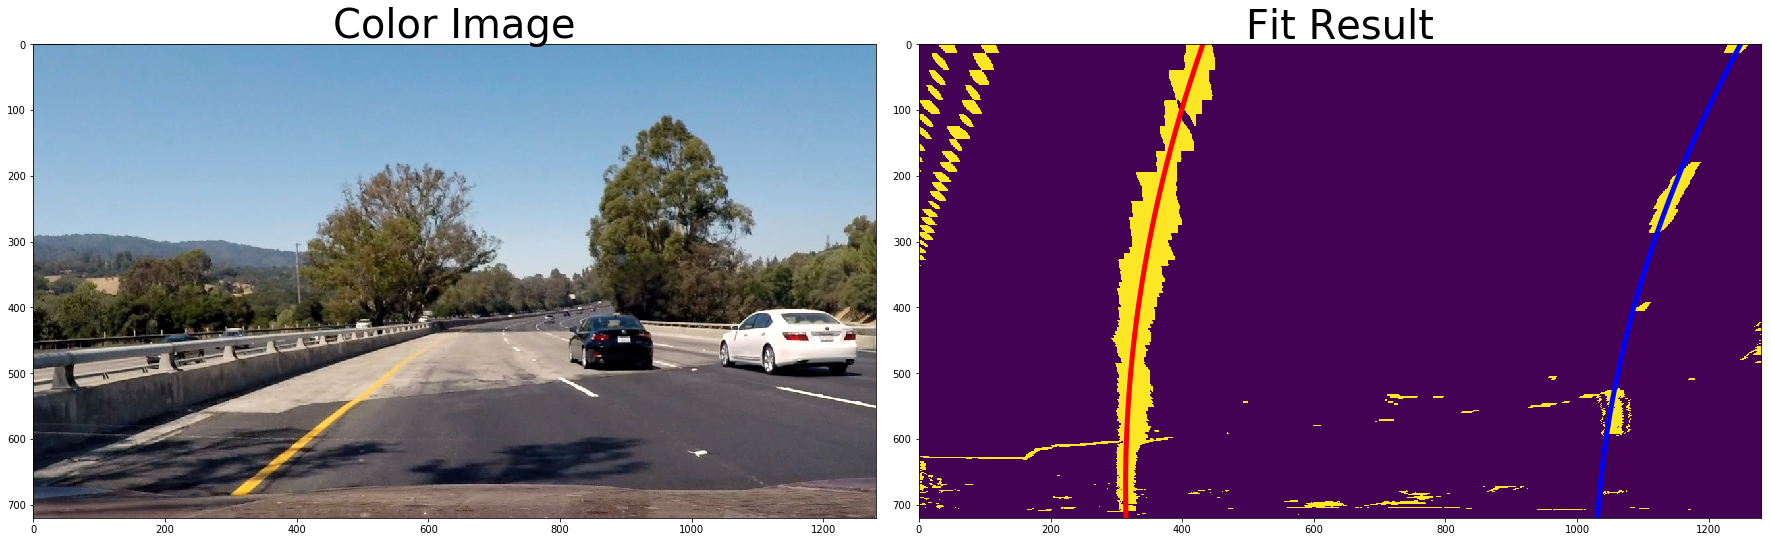

In [10]:
images = glob.glob('../test_images/test*.jpg')
tst_img = mpimg.imread(images[3])

margin = 100
ploty = np.linspace(0, tst_img.shape[0]-1, tst_img.shape[0])
line = Line()

binary = binary_image(tst_img)
warped, M = perspective_transform(binary)
line = sliding_window(warped, 1, line)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(tst_img)
ax1.set_title('Color Image', fontsize=40)

ax2.imshow(warped)
ax2.plot(line.recent_xfitted[0], ploty, color='red', linewidth=5.0)
ax2.plot(line.recent_xfitted[1], ploty, color='blue', linewidth=5.0)
ax2.set_title('Fit Result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig("../output_images/bad1.jpg")

---
## 7. Determine the curvature of the lane and vehicle position with respect to center.

In [11]:
def curvature(line):
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, line.recent_xfitted[0]*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, line.recent_xfitted[1]*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return int((left_curverad + right_curverad)/2)

def center_x(line):
    leftx = line.recent_xfitted[0][-1]
    rightx = line.recent_xfitted[1][-1]
    return np.abs((rightx + leftx)/2 - centerx) * xm_per_pix
    

---
## 7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
Saved the images in output_images/result, and generate video with video.py

In [ ]:
def countHelper(count):
    if count < 10:
        return "000" + str(count)
    elif count < 100:
        return "00" + str(count)
    elif count < 1000:
        return "0" + str(count)
    else:
        return str(count)

def draw(image, undist, warped, M, line, filename):
    if not line.detected:
        cv2.imwrite(filename + ".jpg", cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        return
    
    left_fitx = line.bestx[0]
    right_fitx = line.bestx[1]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, np.linalg.inv(M), (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    # Print curvature and center on image
    radius = "Radius of Curvature = {0}(m)".format(curvature(line))
    center = "Vehicle is {0:.2f}m left of center".format(center_x(line))
    
    result = cv2.putText(result, radius, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2)
    result = cv2.putText(result, center, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2)
    cv2.imwrite(filename + ".jpg", result)


---
## 8. Pipeline

In [ ]:
plt.ioff()
# Read image from video
vidcap = cv2.VideoCapture('../project_video.mp4')
success,image = vidcap.read()

margin = 100
ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
centerx = np.floor(image.shape[1]/2)

count = 0
success = True
line = Line()
while success:
    print('Read a new frame: {0}, {1} '.format(str(count), success))
    undistorted = cal_undistort(image)
    binary = binary_image(undistorted, sx_thresh=(60,120), s_thresh=(160, 255))
    warped, M = perspective_transform(binary)
    if line.detected:
        line = look_ahead(warped, count, line)
    else:
        line = sliding_window(warped, count, line)
    filename = "../output_images/result/image" + countHelper(count)
    draw(img, undistorted, warped, M, line, filename)
    
    count += 1
    success,image = vidcap.read()

print("Succeed")

Read a new frame: 0, True 
Read a new frame: 1, True 
Look ahead sanity check failed for image 1, fallback to sliding window
Read a new frame: 2, True 
Look ahead sanity check failed for image 2, fallback to sliding window
Read a new frame: 3, True 
Look ahead sanity check failed for image 3, fallback to sliding window
Read a new frame: 4, True 
Read a new frame: 5, True 
Read a new frame: 6, True 
Read a new frame: 7, True 
Read a new frame: 8, True 
Read a new frame: 9, True 
Read a new frame: 10, True 
Read a new frame: 11, True 
Read a new frame: 12, True 
Read a new frame: 13, True 
Look ahead sanity check failed for image 13, fallback to sliding window
Read a new frame: 14, True 
Look ahead sanity check failed for image 14, fallback to sliding window
Read a new frame: 15, True 
Look ahead sanity check failed for image 15, fallback to sliding window
Read a new frame: 16, True 
Read a new frame: 17, True 
Read a new frame: 18, True 
Read a new frame: 19, True 
Read a new frame: 20,